# import packages

In [1]:
#Import Pacakges
import pandas as pd
from sbmtm import sbmtm
import graph_tool.all as gt
import pickle
import numpy as np
import pylab as plt
import seaborn as sns
from datetime import datetime
from dateutil import parser
from collections import defaultdict

In [2]:
def mcc_classification(mcc):
    if mcc < 1500:
        return 'Agricultural Services'
    elif mcc < 3000:
        return 'Contracted Services'
    elif mcc < 4800:
        return 'Travel'
    elif mcc < 5000:
        return 'Utility Services'
    elif mcc < 5600:
        return 'Retail Outlet Services'
    elif mcc < 5700:
        return 'Clothing Stores'
    elif mcc < 7300:
        return 'Miscellaneous Stores'
    elif mcc < 8000:
        return 'Business Services'
    elif mcc < 9000:
        return 'Professional Services and Membership Organizations'
    else:
        return 'Government Services'

In [3]:
#filtered_data = pd.read_csv('/Users/ognyansimeonov/Desktop/MAC-MIGS/PhD/Code/Data/Transactions_Data_with_COICOP.csv')
filtered_data = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='Clean_Transfers')
mcc_dict = pd.read_excel('ekko_Data_MSc.xlsx', sheet_name='MCC_List', skiprows=10, usecols='A:B', names=['mcc_code', 'Description'])

### data cleaning

# deal with mcc that are classified into multiple categories (keep the main category)
tempdf = filtered_data.groupby('MCC_List')['externalParty.transactionCategory'].value_counts(ascending=False).reset_index()
tempdf = tempdf.drop_duplicates(subset=['MCC_List'], keep='first')
# remap the categories to the filtered_data
filtered_data['externalParty.transactionCategory'] = filtered_data['MCC_List'].map(tempdf.set_index('MCC_List')['externalParty.transactionCategory'])

# select transactions with amount > 10
filtered_data = filtered_data[filtered_data['amount.value'] > 10]
# select customers with more than 10 transactions
filtered_data = filtered_data[filtered_data['customerId'].map(filtered_data['customerId'].value_counts()) > 10]
# map the mcc_dict to the filtered_data and drop the rows with NaN MCC values
filtered_data['MCC_List'] = filtered_data['externalParty.merchantCategoryCode'].map(mcc_dict.set_index('mcc_code')['Description'])
filtered_data = filtered_data.dropna(subset=['MCC_List'])
# fill the missing carbon emission values with the calculated carbon emission values based on the emission rate of the MCC
# calculate the emission rate of each transaction
filtered_data['emission_rate'] = filtered_data.apply(lambda x: x['transactionFootPrint.carbonEmissionInGrams']/x['amount.value'] if x['amount.value']!=0 else 0, axis=1)
# find the emission rate of each MCC
df_emission_rate = filtered_data.groupby('MCC_List')['emission_rate'].max().sort_values(ascending=True).reset_index().set_index('MCC_List').fillna(0)
# calculate the carbon emission of each transaction where missing
filtered_data['transactionFootPrint.carbonEmissionInGrams'] = filtered_data.apply(lambda x: x['amount.value']*df_emission_rate.loc[x['MCC_List']], axis=1)
filtered_data['mcc_classification'] = filtered_data['externalParty.merchantCategoryCode'].apply(mcc_classification)

df = filtered_data 

# Create a dictionary to store MCC lists for each customer
customer_mcc_dict = {}

# Iterate through the dataframe
for _, row in df.iterrows():
    customer_id = row['customerId']
    mcc = row['MCC_List']

    # Check if the customer_id is already in the dictionary
    if customer_id in customer_mcc_dict:
        customer_mcc_dict[customer_id].append(mcc)
    else:
        customer_mcc_dict[customer_id] = [mcc]

# build a network

<Axes: ylabel='Frequency'>

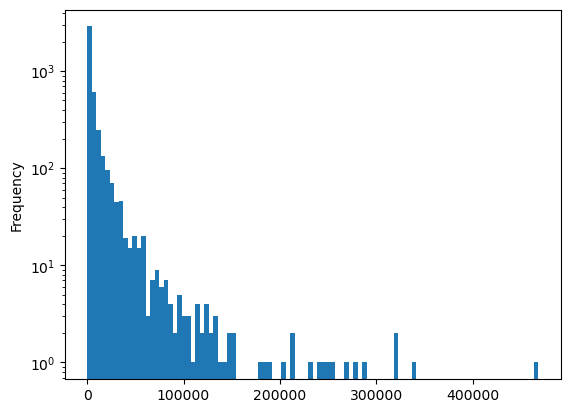

In [4]:
df_weight_network = filtered_data.groupby(['customerId','MCC_List'])['amount.value'].sum().reset_index()
df_weight_network['amount.value'].plot(
                                        kind='hist'
                                       , bins=100
                                       , logy=True
                                       )

In [5]:
df_weight_network

,customerId,MCC_List,amount.value
0,01968de9-41cb-4509-b0a6-6bdc02700150,Bakeries,1265
1,01968de9-41cb-4509-b0a6-6bdc02700150,Beauty and Barber Shops,5057
2,01968de9-41cb-4509-b0a6-6bdc02700150,"Bus Lines, includes Charters/Tour Buses",3570
3,01968de9-41cb-4509-b0a6-6bdc02700150,"Candy, Nut, and Confectionary Stores",490
4,01968de9-41cb-4509-b0a6-6bdc02700150,Caterers - Prepare & Delivery,1445
...,...,...,...
4317,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Shoe Stores,4319
4318,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Sporting and Recreational Camps,1465
4319,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,"Stationery, Office and School Supply Stores",2240
4320,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,Tourist Attractions and Exhibits,200


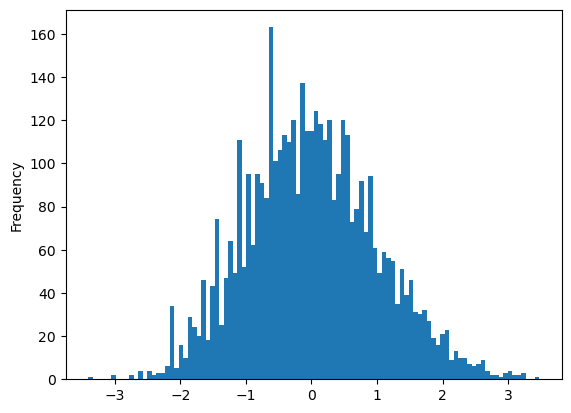

In [6]:
df_weight_network['log_amount'] = np.log10(df_weight_network['amount.value'])
# normalize the log_amount
df_weight_network['log_amount'] = (df_weight_network['log_amount'] - df_weight_network['log_amount'].mean()) / df_weight_network['log_amount'].std()
df_weight_network['log_amount'].plot(
                                        kind='hist'
                                       , bins=100
                                    #    , logy=True
                                       )
plt.show()

In [7]:
# build a weighted network
g = gt.Graph(directed=False)
# difine the node properties
## name: docs - title, words - 'word'
## kind: docs(customers) - 0, words(mcc) - 1
name = g.vp['name'] = g.new_vp('string')
kind = g.vp['kind'] = g.new_vp('int')
## define the edge properties
weight = g.ep['weight'] = g.new_ep('double')

docs_add = defaultdict(lambda: g.add_vertex())
words_add = defaultdict(lambda: g.add_vertex())

for _, row in df_weight_network.iterrows():
    customer = row['customerId']
    mcc = row['MCC_List']
    weight = row['log_amount']
    # weight = row['amount.value']
    # add customer node
    docs = docs_add[customer]
    name[docs] = customer
    kind[docs] = 0
    # add mcc node
    words = words_add[mcc]
    name[words] = mcc
    kind[words] = 1
    edge = g.edge(docs, words)
    if edge is None:
        edge = g.add_edge(docs, words)
        g.ep['weight'][edge] = 0
    g.ep['weight'][edge] += weight

In [8]:
g

<Graph object, undirected, with 568 vertices and 4322 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f008ea023f0>

# Nested SBM

In [9]:
SEED = 41
gt.seed_rng(SEED)

n_init = 100
clabel = g.vp['kind']

state_args = {
    'clabel': clabel
    , 'pclabel': clabel
    # , 'eweight': g.ep['weight']
    , 'recs':[g.ep['weight']]
    # , 'rec_types': ['real-exponential']
    , 'rec_types': ['real-normal']
}

mdl = np.inf
for i_n_init in range(n_init):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(g
                                                 ,state_args=dict(base_type=base_type,deg_corr=True,**state_args)
                                                 ,multilevel_mcmc_args=dict(niter=10, verbose=False)
                                                 )
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])
    print(state_tmp.entropy())

    mdl_tmp = state_tmp.entropy()
    if mdl_tmp < mdl:
        mdl = 1.0*mdl_tmp
        state = state_tmp.copy()

g.state = state
g.mdl = state.entropy()
L = len(state.levels)
if L == 2:
    g.L = 1
else:
    g.L = L-2

17991.691245002185
17991.691245002185
17991.691245002185
17991.691245002185
17986.385659669355
17984.479154809742
17991.691245002185
17991.691245002185
17986.385659669355
17991.691245002185
17968.865061312103
17986.385659669355
17984.18149790675
17991.691245002185
17986.385659669355
17982.046014855427
17991.691245002185
17984.18149790675
17986.385659669355
17991.691245002185
17979.75949231633
17991.691245002185
17976.438976358455
17991.691245002185
17983.660894172328
17991.691245002185
17984.479154809742
17991.691245002185
17986.59319141337
17983.355705075894
17991.691245002185
17991.691245002185
17991.691245002185
17984.18149790675
17991.691245002185
17964.12412134521
17991.691245002185
17991.691245002185
17987.321258632885
17979.75949231633
17991.691245002185
17984.18130891881
17991.691245002185
17983.355705075894
17986.385659669355
17986.385659669355
17991.691245002185
17971.125408207423
17991.691245002185


In [10]:
print('The lowest entropy was {}, and the state has {} blocks at level 1'.format(g.state.entropy(),g.state.get_levels()[1].get_nonempty_B()))

The lowest entropy was 17971.125408207423, and the state has 2 blocks at level 1


In [21]:
g.state

<NestedBlockState object, with base <BlockState object with 568 blocks (3 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 568 vertices and 4322 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f875db684a0>, at 0x7f875dc4f9e0>, and 3 levels of sizes [(568, 3), (3, 2), (2, 1)] at 0x7f875dc4f410>

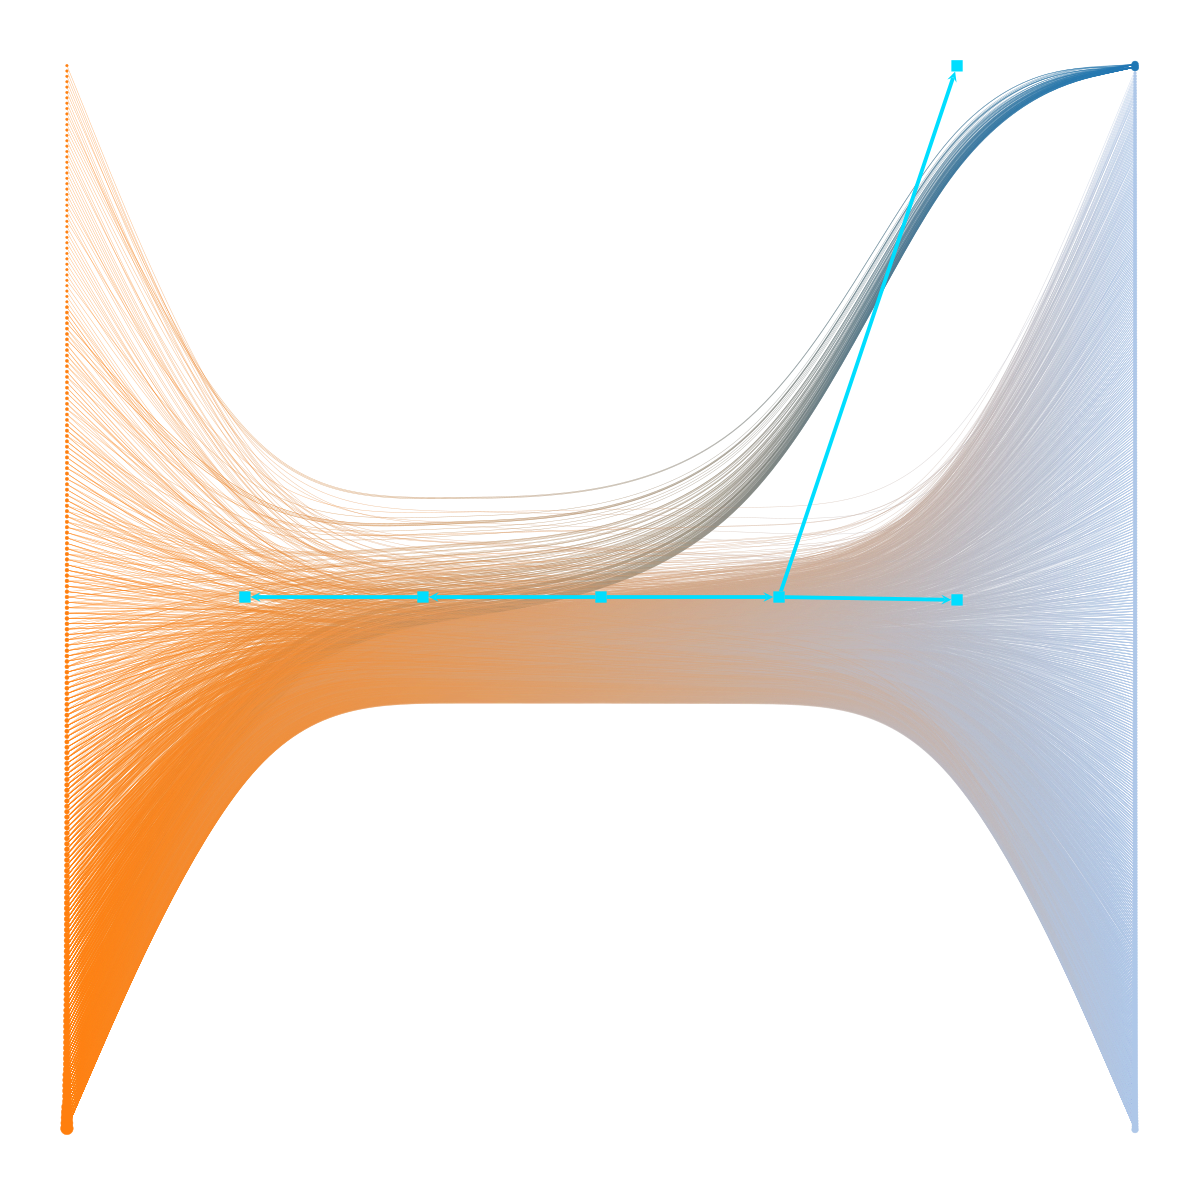

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f875db684a0, at 0x7f875e8ba210>,
 <GraphView object, directed, with 574 vertices and 573 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f875cedee10, at 0x7f875dc4df10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f875cedee10, at 0x7f875dc4e0f0>, False), at 0x7f875cedee10>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f875cedee10, at 0x7f875dbfbaa0>)

In [12]:
g.state.draw(subsample_edges=10000,layout='bipartite',bip_aspect=1,
           hvertex_size=8, hedge_pen_width=1.9, hedge_color="#00deff", hvertex_fill_color="#00DEFF", output_size=(600, 600))

In [13]:
state_l0 = g.state.project_level(0).copy()
state_l1 = g.state.project_level(1).copy()

In [14]:
b0 = gt.contiguous_map(state_l0.b)
b1 = gt.contiguous_map(state_l1.b)
label_map = {}
for v in g.vertices():
    label_map[state_l0.b[v]] = b0[v]
state_l0 = state_l0.copy(b=b0)
state_l1 = state_l1.copy(b=b1)

In [15]:
# create a dict for nodes and their blocks
blocks = {}
for v in g.vertices():
    blocks[name[v]] = [kind[v], state_l1.get_blocks()[v], state_l0.get_blocks()[v]]

In [16]:
df_clusters = pd.DataFrame.from_dict(blocks, orient='index', columns=['kind', 'level_1', 'level_0']).reset_index()
df_clusters = df_clusters.rename(columns={'index':'node'})
df_clusters['node'] = df_clusters['node'].astype(str)
df_clusters['levels'] = df_clusters['level_1'].astype(str) + '_' + df_clusters['level_0'].astype(str)
df_clusters.sort_values(by=['kind','level_1','level_0'], ascending=True, inplace=True)
df_clusters = df_clusters[df_clusters['kind'] == 0].reset_index(drop=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters

,node,kind,level_1,level_0,levels
0,01968de9-41cb-4509-b0a6-6bdc02700150,0,0,0,0_0
1,01b34ce5-ce43-4c2d-a73d-5294376bd399,0,0,0,0_0
2,01b4698f-32be-4bc0-9b69-b3024ac18004,0,0,0,0_0
3,01ef943c-d661-48b0-9c0b-bb456a7d998d,0,0,0,0_0
4,03025a2b-9179-4da9-8dff-af4a3179ce7f,0,0,0,0_0
...,...,...,...,...,...
364,feb37e88-b280-40b8-b887-30961016417c,0,0,0,0_0
365,ff6ef7e8-4b43-44f7-a1ef-7d35407c2219,0,0,0,0_0
366,ffcf3506-a7d8-48a0-ba54-d4d54d15ee78,0,0,0,0_0
367,3253926e-9c0d-4fd9-8248-eb7c2f457b99,0,0,2,0_2


Block 0 has 367 nodes
Block 2 has 2 nodes


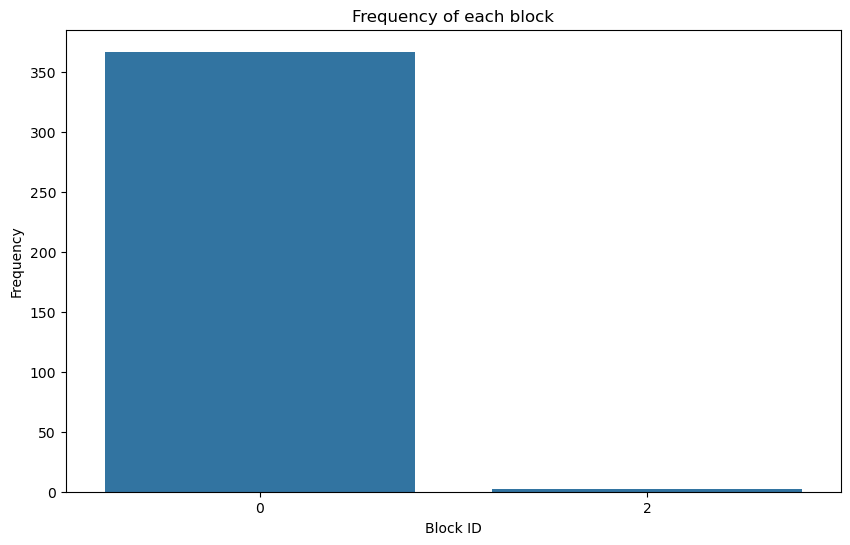

In [19]:
# calculate the frequency of each block and sort them by the id of the block
block_freq = {}
l=0
for i in df_clusters['level_{}'.format(l)].unique():
    # block_freq[str(i)] = len([x for x in b if x == i])
    block_freq[i] = len(df_clusters[df_clusters['level_{}'.format(l)] == i])
    print('Block {} has {} nodes'.format(i, block_freq[i]))
# plot the frequency of each block
plt.figure(figsize=(10, 6))
sns.barplot(x=list(block_freq.keys()), y=list(block_freq.values()))
plt.xlabel('Block ID')
plt.ylabel('Frequency')
plt.title('Frequency of each block')
plt.show()

## Heatmaps of Purchases by Cluster

In [22]:
def heatmaps(df_clusters, df, yvalues=['MCC_List'], xvalues=['levels'], topn=False, relative=False, value='frequency', level_detail=False, max_label_len=False):
    '''
    df_clusters: DataFrame, the DataFrame with the cluster information
    df: DataFrame, the DataFrame with the transactions data
    yvalues: list, hierarchical levels to be used as y-axis values (categories)
    xvalues: list, hierarchical levels to be used as x-axis values (levels)
    topn: int, the number of top categories to be shown in the heatmap, valid only if yvalues has one level
    relative: bool, if True, the heatmap will show the relative frequency of the categories
    '''
    if len(yvalues) == 2:
        df['y'] = df[yvalues[0]] + '_' + df[yvalues[1]]
        annot = False
        ytick = False
    else:
        df['y'] = df[yvalues[0]]
        annot = True
        ytick = True
    # population average of the transactions frequency/amount for calculating the relative frequency
    if value == 'frequency':
        df_avg = df['y'].value_counts(normalize=True).reset_index().set_index('y')
        df['count'] = 1
    elif value == 'amount':
        df_avg = (df.groupby('y')['amount.value'].sum()/df['amount.value'].sum()).rename('proportion').reset_index().set_index('y')
        df['count'] = df['amount.value']

    # Get the normalized MCC transaction counts for each cluster
    cluster_counts = []
    for cluster in df_clusters[xvalues[-1]].unique():
        # Filter the DataFrame based on the customer IDs in the cluster
        custid = df_clusters[df_clusters[xvalues[-1]] == cluster]['node'].values
        filtered_df = df[df['customerId'].isin(custid)]
        if relative:
            # Calculate the normalized counts for each MCC category
            # counts = np.log(filtered_df[yvalues[-1]].value_counts(normalize=True) / df_avg['proportion']).rename(cluster)
            counts = np.log((filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()) / df_avg['proportion']).rename(cluster)
        else:
            counts = (filtered_df.groupby('y')['count'].sum()/filtered_df['count'].sum()).rename(cluster)
        cluster_counts.append(counts)

    # Combine the normalized counts into a single DataFrame
    df_data = pd.concat(cluster_counts, axis=1, sort=True).fillna(0)
    # limit the length of the index
    if max_label_len:
        df_data.index = df_data.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
        df_avg.index = df_avg.index.map(lambda x: x[:max_label_len]+'...' if len(x) > max_label_len else x)
    limit = np.max([np.abs(df_data.min().min()), df_data.max().max()])

    # shows only the top mcc if topn is given
    if topn:
        # Get the top 10 categories with the highest average transaction percentages
        topn_index = df_avg.nlargest(topn, df_avg.keys()[0]).index
        # Filter the DataFrame to keep only the top categories
        df_data = df_data.loc[topn_index]

    # Create a heatmap
    plt.figure(figsize=(18, 10))
    if relative:
        sns.heatmap(df_data, cmap='PiYG', fmt='.2f', annot=annot, linewidths=.5, vmin=-limit, vmax=limit, yticklabels=ytick, xticklabels=level_detail)
    else:
        sns.heatmap(df_data, cmap='Reds', fmt='.2%', annot=annot, linewidths=.5, yticklabels=ytick, xticklabels=level_detail)
    if len(yvalues) == 2:
        for category, y in df.groupby(yvalues[0])['y'].nunique().sort_index().cumsum().items():
            plt.axhline(y=y, color='gray', lw=0.5, linestyle='--')
            plt.text(-1, y-0.5, category, ha='center', va='center', fontsize=8)
    if len(xvalues) == 2:
        y = len(df_data.index)
        for level, x in df_clusters.groupby(xvalues[0])[xvalues[1]].nunique().sort_index().cumsum().items():
            plt.axvline(x=x, color='gray', lw=0.5, linestyle='--')
            if level_detail == False:
                plt.text(x-0.5, y*1.01, level, ha='center', va='center', fontsize=8)
    plt.title('Normalized MCC Categories Heatmap')
    plt.show()

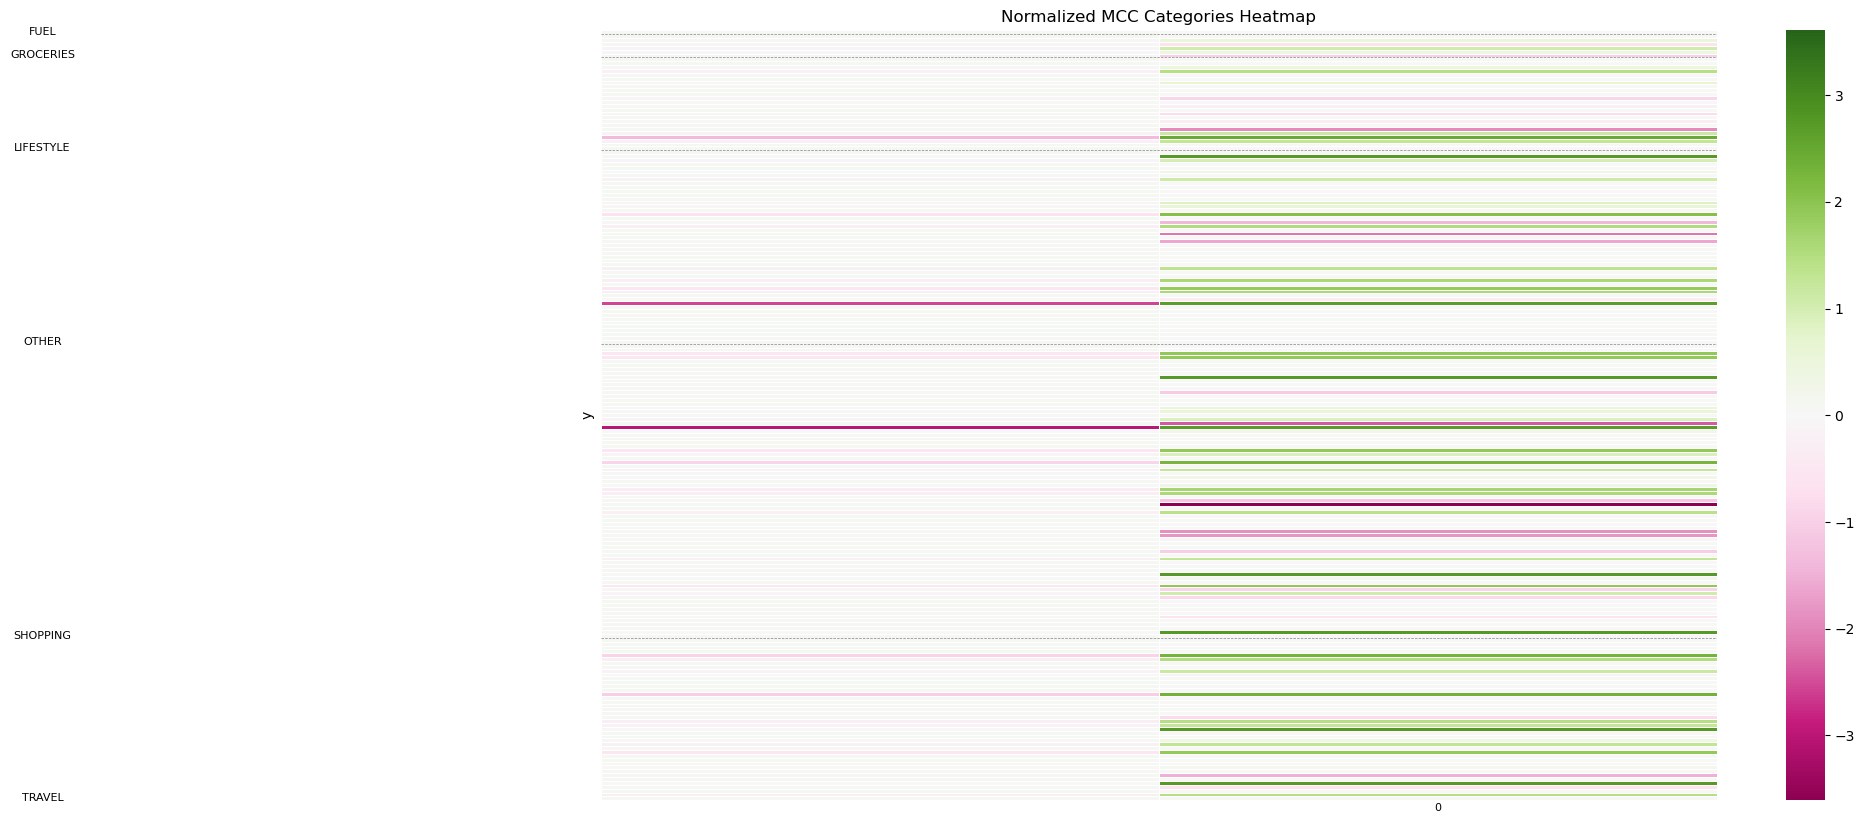

In [23]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory','MCC_List'], xvalues=['level_1','levels'], level_detail=False, value='amount')

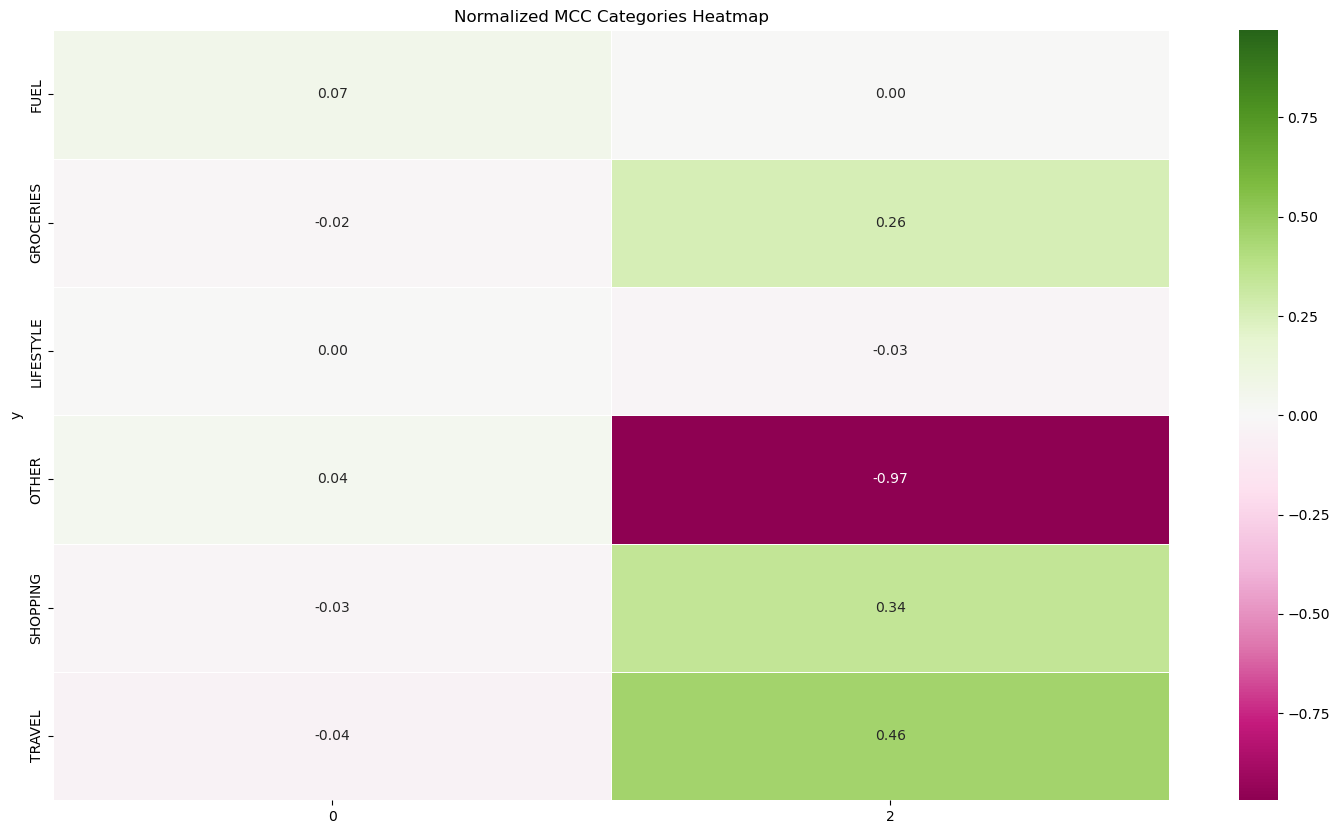

In [25]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], level_detail=True, value='amount')

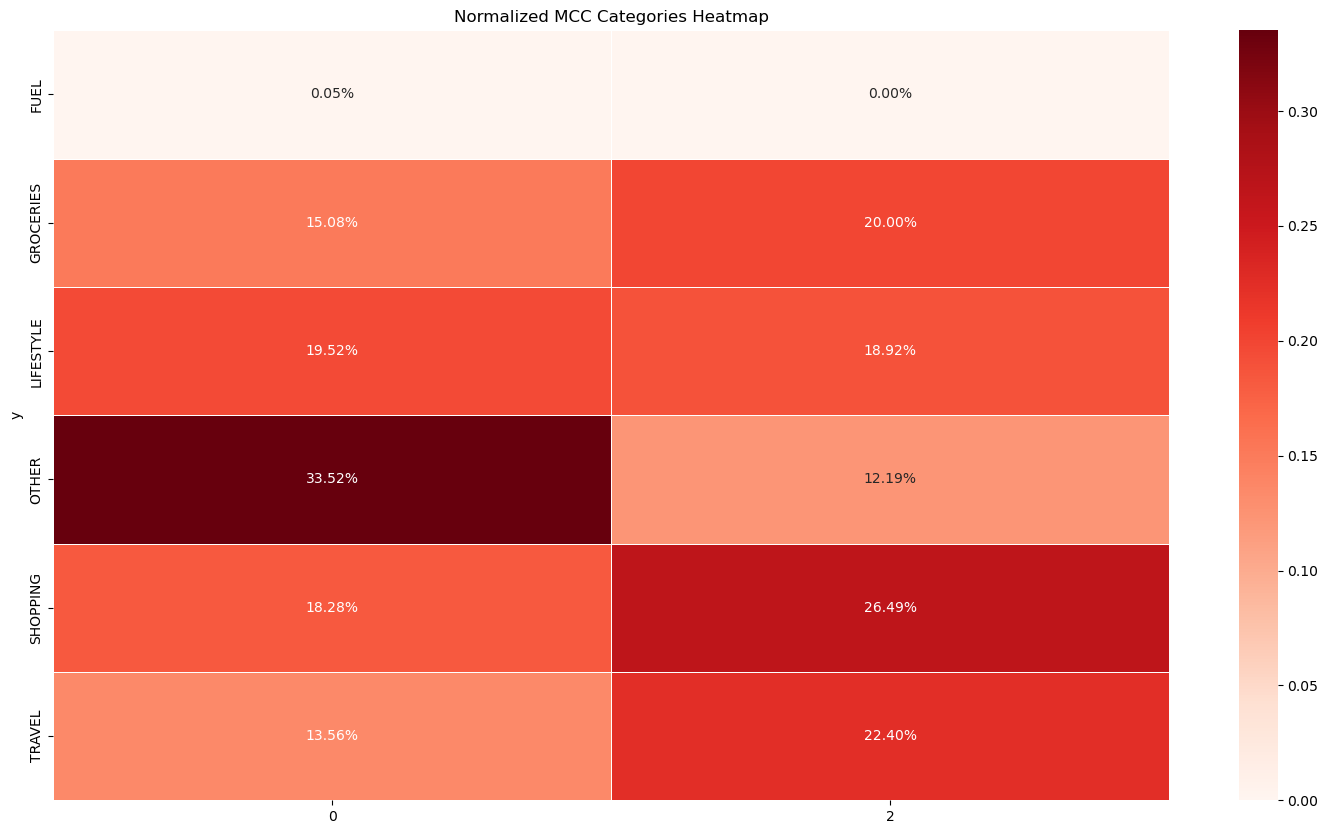

In [26]:
heatmaps(df_clusters, filtered_data, relative=False, yvalues=['externalParty.transactionCategory'], xvalues=['level_0'], level_detail=True, value='amount')

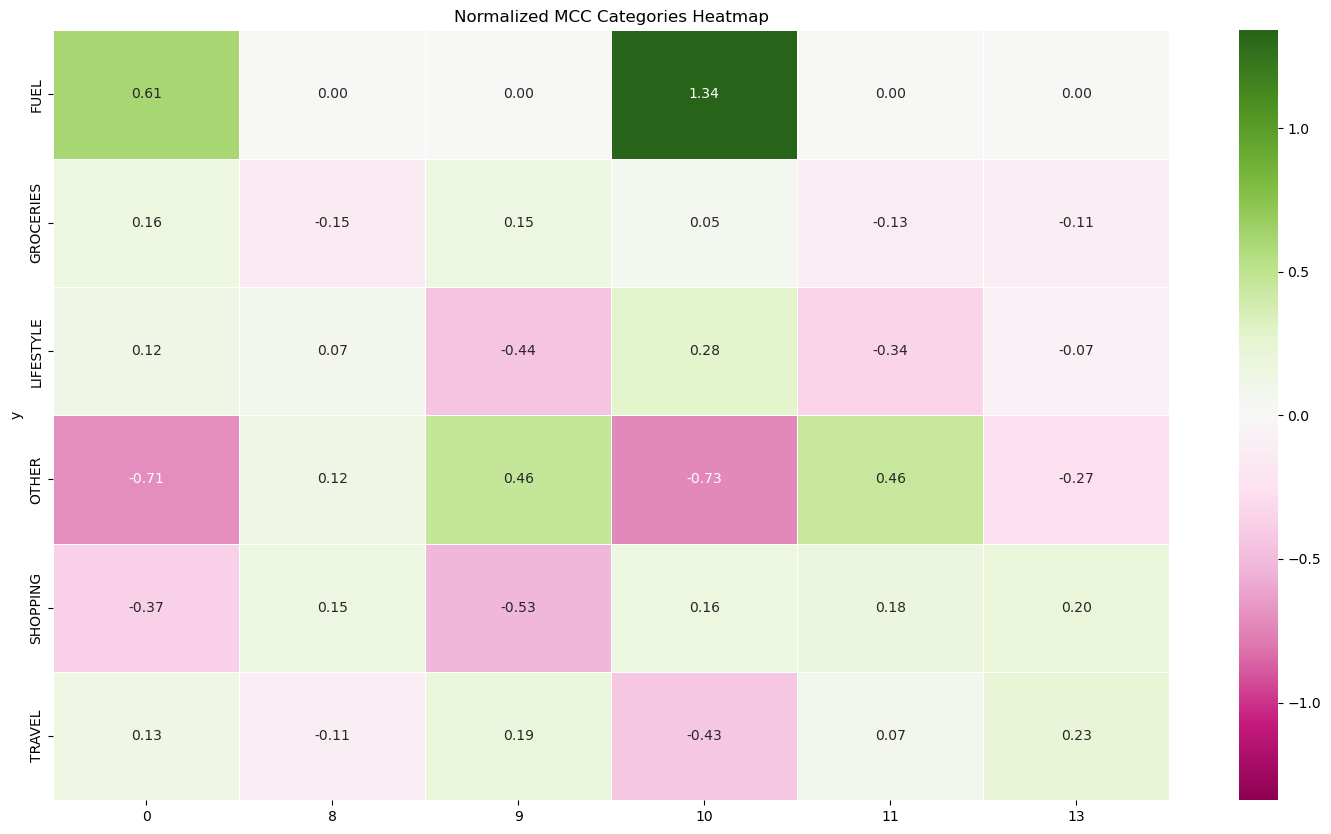

In [22]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['externalParty.transactionCategory'], xvalues=['level_1'], level_detail=True, value='frequency')

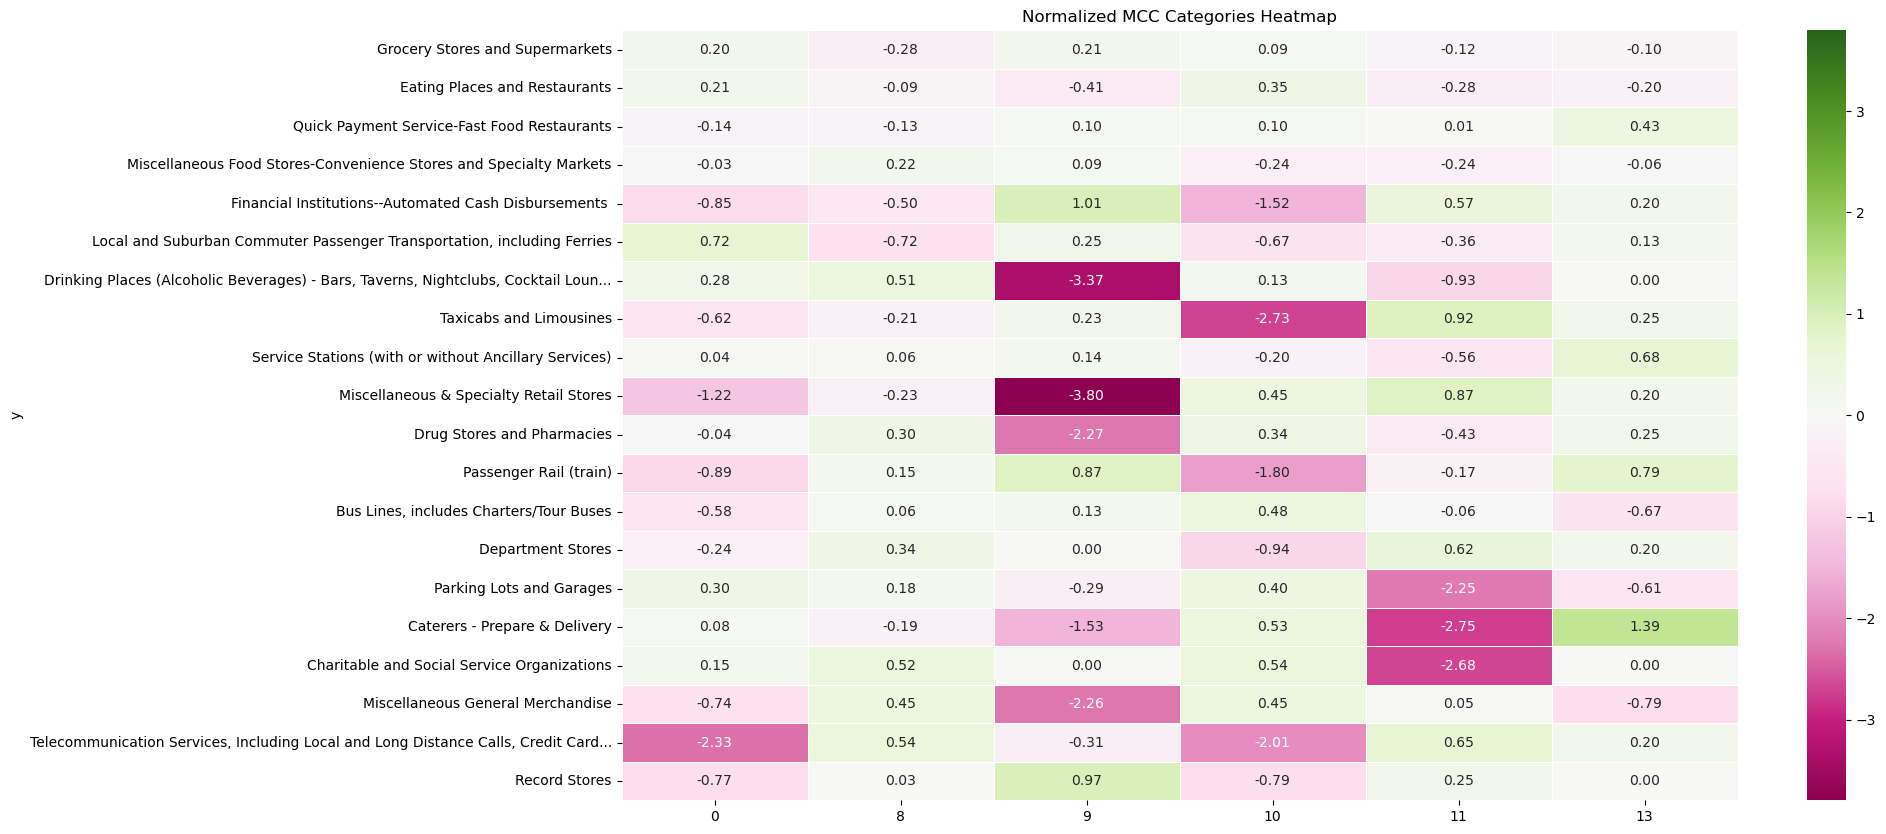

In [23]:
heatmaps(df_clusters, filtered_data, relative=True, yvalues=['MCC_List'], xvalues=['level_1'], level_detail=True, value='frequency', topn=20, max_label_len=80)